<a href="https://colab.research.google.com/github/Ronilmuchandi/economics-of-remote-work-city-opportunity/blob/main/notebooks/04_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering: Opportunity, Mobility, and Fragility Indices

This notebook constructs interpretable economic indices that translate remote work demand, migration dynamics, and cost-of-living pressure into decision-oriented metrics.

Unlike predictive modeling, the goal here is **index design**: creating transparent, normalized measures that capture opportunity and fragility in the remote work economy.

All features are derived from the finalized MSA-level dataset (`master_msa_dataset_final.csv`) and are designed to be interpretable, non-circular, and analytically defensible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv(
    "/content/drive/MyDrive/master_msa_dataset_final.csv"
)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (209, 32)


,msa_a_code,year_month,total_jobs,remote_jobs,remote_share,msa_city,msa_state,total_inflow,total_outflow,net_migration,...,median_family_income,housing_cost.1,food_cost.1,transportation_cost.1,healthcare_cost.1,other_necessities_cost.1,childcare_cost.1,taxes.1,total_cost.1,median_family_income.1
0,10180,2024-04-01,60,3,0.050000,Abilene,TX,15289,12714,1360,...,65228.097656,7518.818080,3001.86972,10906.385000,5389.47984,3812.060080,0.0,4570.41932,35199.03240,65466.664062
1,10420,2024-04-01,124,7,0.056452,Akron,OH,31107,29891,-826,...,77102.312500,6882.068460,3211.10118,9639.235140,4309.34988,3657.153420,0.0,4479.25284,32178.16080,77387.769531
2,10500,2024-04-01,14,3,0.214286,Albany,GA,7915,8209,-725,...,52946.230469,7010.840112,3187.23852,11002.865592,5149.47984,3695.166096,0.0,5788.54968,35834.14056,55871.042969
3,10740,2024-04-01,219,3,0.013699,Albuquerque,NM,36377,36067,-3958,...,69691.710938,7505.500860,3221.47662,10579.807590,3476.37996,3886.807080,0.0,4870.98342,33540.95610,63474.537109
4,10780,2024-04-01,39,1,0.025641,Alexandria,LA,7257,6345,361,...,53466.832031,6141.242400,3081.41208,11032.943460,5545.47984,3341.731560,0.0,5138.70414,34281.51240,56290.089844


## Feature Engineering Philosophy

This notebook focuses on **economic index construction**, not model-driven feature generation.

Each engineered feature follows five rules:

- **Single-purpose**: each index answers one economic question
- **Transparent**: no learned weights or black-box transformations
- **Normalized**: indices are comparable across metropolitan areas
- **Non-circular**: no index is built using another index
- **Economically interpretable**: higher or lower values have clear meaning

These indices are designed for interpretation, comparison, and scenario analysis — not prediction.


## Normalization Strategy

All component variables are standardized using **z-score normalization**:

\[
z = \frac{x - \mu}{\sigma}
\]

Z-scores are used instead of min–max scaling to preserve relative distance from the national average and reduce sensitivity to extreme values. This allows indices to reflect **structural deviation** rather than arbitrary scaling.


In [4]:
from sklearn.preprocessing import StandardScaler

# Variables used for index construction
index_vars = [
    "remote_share",          # opportunity
    "gross_migration",       # mobility
    "total_cost",            # cost pressure
    "median_family_income"   # economic context
]

scaler = StandardScaler()

df_fe = df.copy()
df_fe[[f"{v}_z" for v in index_vars]] = scaler.fit_transform(df[index_vars])

# Quick check
df_fe[[f"{v}_z" for v in index_vars]].describe().round(2)


,remote_share_z,gross_migration_z,total_cost_z,median_family_income_z
count,209.00,209.00,139.00,139.00
mean,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00
min,-1.02,-0.94,-1.49,-2.05
25%,-0.60,-0.63,-0.67,-0.72
50%,-0.22,-0.32,-0.15,-0.06
75%,0.24,0.12,0.38,0.65
max,5.62,4.86,4.83,3.63


In [5]:
# Remote Work Demand Index
df_fe["RWDI"] = df_fe["remote_share_z"]

# Sanity check
df_fe["RWDI"].describe().round(2)


,RWDI
count,209.00
mean,0.00
std,1.00
min,-1.02
25%,-0.60
50%,-0.22
75%,0.24
max,5.62


In [7]:
# Mobility Intensity Score
df_fe["MIS"] = df_fe["gross_migration_z"]

# Sanity check
df_fe["MIS"].describe().round(2)


,MIS
count,209.00
mean,0.00
std,1.00
min,-0.94
25%,-0.63
50%,-0.32
75%,0.12
max,4.86


In [8]:
# Cost Pressure Index
df_fe["CPI"] = df_fe["total_cost_z"]

# Sanity check (only rows with cost data)
df_fe["CPI"].dropna().describe().round(2)


,CPI
count,139.00
mean,-0.00
std,1.00
min,-1.49
25%,-0.67
50%,-0.15
75%,0.38
max,4.83


In [9]:
# Remote Work Opportunity Index
df_fe["RWOI"] = (df_fe["RWDI"] + df_fe["MIS"]) / 2

# Sanity check
df_fe["RWOI"].describe().round(2)


,RWOI
count,209.00
mean,0.00
std,0.64
min,-0.98
25%,-0.38
50%,-0.14
75%,0.30
max,2.45


In [10]:
# Remote Work Fragility Index (signature feature)
df_fe["RWFI"] = df_fe["RWOI"] * df_fe["CPI"] * df_fe["MIS"]

# Sanity check (only rows with cost data)
df_fe["RWFI"].dropna().describe().round(2)


,RWFI
count,139.00
mean,0.00
std,0.62
min,-3.00
25%,-0.14
50%,-0.02
75%,0.03
max,4.33


# Feature Engineering & Index Definitions

This section defines the indices used to quantify opportunity, mobility, cost pressure, and fragility in the remote work economy. All indices are constructed from standardized components and are intended for interpretation, not prediction.

---

## Normalization

All base variables are standardized using z-score normalization:

z = (x − μ) / σ

This measures deviation from the national average and ensures comparability across metropolitan areas.

---

## 1. Remote Work Demand Index (RWDI)

**Purpose:**  
Measures relative intensity of remote job demand.

**Component:**  
- remote_share

**Formula:**  
RWDI = remote_share_z

**Interpretation:**  
- RWDI > 0 → above-average remote job exposure  
- RWDI ≈ 0 → average exposure  
- RWDI < 0 → below-average exposure  

---

## 2. Mobility Intensity Score (MIS)

**Purpose:**  
Captures population churn and instability, independent of direction.

**Component:**  
- gross_migration

**Formula:**  
MIS = gross_migration_z

**Interpretation:**  
- MIS > 0 → high mobility / instability  
- MIS ≈ 0 → average mobility  
- MIS < 0 → stable population  

---

## 3. Cost Pressure Index (CPI)

**Purpose:**  
Measures structural affordability pressure.

**Component:**  
- total_cost

**Formula:**  
CPI = total_cost_z

**Interpretation:**  
- CPI > 0 → above-average cost pressure  
- CPI ≈ 0 → typical cost levels  
- CPI < 0 → relatively affordable  

---

## 4. Remote Work Opportunity Index (RWOI)

**Purpose:**  
Combines remote demand with population response.

**Components:**  
- RWDI  
- MIS  

**Formula:**  
RWOI = (RWDI + MIS) / 2

**Interpretation:**  
- RWOI > 0 → strong opportunity signal  
- RWOI ≈ 0 → neutral opportunity  
- RWOI < 0 → limited or stagnant opportunity  

---

## 5. Remote Work Fragility Index (RWFI) ⭐

**Purpose:**  
Identifies cities where opportunity exists but sustainability may be fragile.

**Concept:**  
Fragility emerges when opportunity, cost pressure, and instability coexist.

**Components:**  
- RWOI (opportunity)  
- CPI (cost pressure)  
- MIS (instability)

**Formula:**  
RWFI = RWOI × CPI × MIS

**Interpretation:**  
- RWFI >> 0 → high opportunity + high cost + high instability (fragile)  
- RWFI ≈ 0 → stabilizing forces present  
- RWFI < 0 → opportunity with lower pressure or volatility (more resilient)

RWFI is a stress indicator, not a ranking or prediction.

---

## Notes & Limitations

- Indices are relative, not absolute measures  
- Equal weighting is intentional and transparent  
- No causal claims or forecasting  
- Appropriate for exploratory and academic analysis


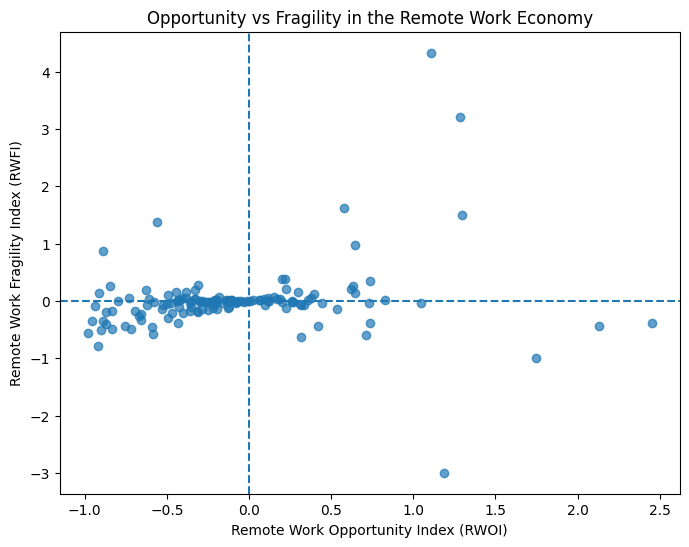

In [12]:
import matplotlib.pyplot as plt

plot_df = df_fe.dropna(subset=["RWFI"])

plt.figure(figsize=(8, 6))
plt.scatter(
    plot_df["RWOI"],
    plot_df["RWFI"],
    alpha=0.7
)

plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")

plt.xlabel("Remote Work Opportunity Index (RWOI)")
plt.ylabel("Remote Work Fragility Index (RWFI)")
plt.title("Opportunity vs Fragility in the Remote Work Economy")

plt.show()

Opportunity vs Fragility in the Remote Work Economy

This scatter plot maps metropolitan areas by their Remote Work Opportunity Index (RWOI) on the x-axis and Remote Work Fragility Index (RWFI) on the y-axis. The vertical and horizontal reference lines at zero divide cities into four structural regimes.

Cities in the top-right quadrant exhibit both high remote work opportunity and high fragility, indicating locations where remote demand and population movement coexist with elevated cost pressure and instability. These metros may experience rapid growth but face sustainability risks. In contrast, the bottom-right quadrant represents cities with strong remote opportunity and low fragility, suggesting more resilient configurations where opportunity is not accompanied by excessive cost or volatility. Cities on the left side of the plot show limited remote opportunity regardless of fragility, reflecting weaker integration into the remote work economy.

Overall, the figure demonstrates that remote work opportunity and fragility are not mechanically linked. High opportunity does not automatically imply high risk, reinforcing the need to evaluate growth and sustainability jointly rather than relying on demand signals alone.

In [13]:
# Keep only rows with RWFI (cost data present)
qdf = df_fe.dropna(subset=["RWFI"]).copy()

# Define quadrants
qdf["quadrant"] = "Other"
qdf.loc[(qdf["RWOI"] > 0) & (qdf["RWFI"] > 0), "quadrant"] = "High Opportunity / High Fragility"
qdf.loc[(qdf["RWOI"] > 0) & (qdf["RWFI"] < 0), "quadrant"] = "High Opportunity / Low Fragility"
qdf.loc[(qdf["RWOI"] < 0) & (qdf["RWFI"] > 0), "quadrant"] = "Low Opportunity / High Fragility"
qdf.loc[(qdf["RWOI"] < 0) & (qdf["RWFI"] < 0), "quadrant"] = "Low Opportunity / Low Fragility"

qdf["quadrant"].value_counts()


,count
quadrant,
Low Opportunity / Low Fragility,61
Low Opportunity / High Fragility,29
High Opportunity / High Fragility,27
High Opportunity / Low Fragility,22


## Distribution of Cities Across Opportunity–Fragility Regimes

The quadrant distribution highlights how metropolitan areas are structurally positioned within the remote work economy.

The largest group consists of **Low Opportunity / Low Fragility** cities (61 MSAs), representing stable metros with limited exposure to remote work demand and relatively low economic stress. These cities form the structural baseline of the dataset.

A substantial number of cities fall into the **Low Opportunity / High Fragility** quadrant (29 MSAs), indicating locations that face elevated cost pressure or instability without corresponding remote work opportunity. This configuration reflects **pressure without payoff**, where economic stress is not offset by new labor market access.

Notably, **High Opportunity / High Fragility** cities (27 MSAs) represent a meaningful share of the sample. These metros exhibit strong remote work opportunity alongside high cost pressure and instability, suggesting **potentially hype-driven or unsustainable growth patterns**. This group motivates the need for a fragility-aware lens rather than opportunity-based rankings.

Finally, **High Opportunity / Low Fragility** cities (22 MSAs) form the smallest but most desirable group. These metros combine above-average remote opportunity with lower structural fragility, indicating **more resilient configurations** where growth is not immediately undermined by cost or volatility.

Overall, the distribution shows that remote work opportunity does not dominate the urban landscape uniformly. Instead, cities are spread across distinct structural regimes, reinforcing the importance of evaluating opportunity and fragility jointly.


In [16]:
import numpy as np
import plotly.express as px

# --- State centroid reference (offline, stable) ---
state_centroids = {
    "AL": (32.806671, -86.791130), "AK": (61.370716, -152.404419),
    "AZ": (33.729759, -111.431221), "AR": (34.969704, -92.373123),
    "CA": (36.116203, -119.681564), "CO": (39.059811, -105.311104),
    "CT": (41.597782, -72.755371), "DE": (39.318523, -75.507141),
    "FL": (27.766279, -81.686783), "GA": (33.040619, -83.643074),
    "HI": (21.094318, -157.498337), "ID": (44.240459, -114.478828),
    "IL": (40.349457, -88.986137), "IN": (39.849426, -86.258278),
    "IA": (42.011539, -93.210526), "KS": (38.526600, -96.726486),
    "KY": (37.668140, -84.670067), "LA": (31.169546, -91.867805),
    "ME": (44.693947, -69.381927), "MD": (39.063946, -76.802101),
    "MA": (42.230171, -71.530106), "MI": (43.326618, -84.536095),
    "MN": (45.694454, -93.900192), "MS": (32.741646, -89.678696),
    "MO": (38.456085, -92.288368), "MT": (46.921925, -110.454353),
    "NE": (41.125370, -98.268082), "NV": (38.313515, -117.055374),
    "NH": (43.452492, -71.563896), "NJ": (40.298904, -74.521011),
    "NM": (34.840515, -106.248482), "NY": (42.165726, -74.948051),
    "NC": (35.630066, -79.806419), "ND": (47.528912, -99.784012),
    "OH": (40.388783, -82.764915), "OK": (35.565342, -96.928917),
    "OR": (44.572021, -122.070938), "PA": (40.590752, -77.209755),
    "RI": (41.680893, -71.511780), "SC": (33.856892, -80.945007),
    "SD": (44.299782, -99.438828), "TN": (35.747845, -86.692345),
    "TX": (31.054487, -97.563461), "UT": (40.150032, -111.862434),
    "VT": (44.045876, -72.710686), "VA": (37.769337, -78.169968),
    "WA": (47.400902, -121.490494), "WV": (38.491226, -80.954453),
    "WI": (44.268543, -89.616508), "WY": (42.755966, -107.302490),
}

# --- Build map frame (use only rows where RWFI exists => cost present) ---
m = df_fe.dropna(subset=["RWFI"]).copy()

# Quadrants
m["quadrant"] = "Other"
m.loc[(m["RWOI"] > 0) & (m["RWFI"] > 0), "quadrant"] = "High Opp / High Frag"
m.loc[(m["RWOI"] > 0) & (m["RWFI"] < 0), "quadrant"] = "High Opp / Low Frag"
m.loc[(m["RWOI"] < 0) & (m["RWFI"] > 0), "quadrant"] = "Low Opp / High Frag"
m.loc[(m["RWOI"] < 0) & (m["RWFI"] < 0), "quadrant"] = "Low Opp / Low Frag"

# State from city_state
m["state"] = m["city_state"].str.split(",").str[1].str.strip().str.upper()

# Map to centroid coords
m["lat"] = m["state"].map(lambda x: state_centroids.get(x, (None, None))[0])
m["lon"] = m["state"].map(lambda x: state_centroids.get(x, (None, None))[1])
m = m.dropna(subset=["lat", "lon"])

# Jitter so points don't overlap
np.random.seed(42)
m["lat"] = m["lat"] + np.random.normal(0, 0.35, len(m))
m["lon"] = m["lon"] + np.random.normal(0, 0.35, len(m))

# Size by magnitude of fragility (stronger signal pops visually)
m["RWFI_abs"] = m["RWFI"].abs()

print("Cities plotted:", m.shape[0])

fig = px.scatter_geo(
    m,
    lat="lat",
    lon="lon",
    color="quadrant",
    size="RWFI_abs",
    size_max=26,
    hover_name="city_state",
    hover_data={
        "quadrant": True,
        "RWOI": ":.2f",
        "RWFI": ":.2f",
        "RWDI": ":.2f",
        "CPI": ":.2f",
        "MIS": ":.2f",
        "RWFI_abs": False,
        "lat": False,
        "lon": False
    },
    scope="usa",
    title="US MSAs: Opportunity–Fragility Regimes (Color) and Fragility Magnitude (Size)"
)

fig.update_layout(
    legend_title_text="Regime (Quadrant)",
    geo=dict(showland=True, landcolor="rgb(245,245,245)")
)

fig.show()


Cities plotted: 139


MSA positions are approximated using state centroid coordinates with jitter to visualize regional patterns rather than exact geography.

In [17]:
good_opportunity = df_fe[
    (df_fe["RWOI"] > 0)
].sort_values("RWOI", ascending=False)[
    ["city_state", "RWOI", "RWDI", "MIS", "CPI", "RWFI"]
]

print("Cities with good opportunity:", good_opportunity.shape[0])
good_opportunity.head(20)


Cities with good opportunity: 83


,city_state,RWOI,RWDI,MIS,CPI,RWFI
54,"el centro, ca",2.450990,5.615473,-0.713492,0.219187,-0.383307
42,"columbus, oh",2.339925,-0.176872,4.856723,NaN,NaN
52,"east stroudsburg, pa",2.130628,4.667360,-0.406103,0.514492,-0.445167
93,"jacksonville, fl",2.083231,-0.376966,4.543427,NaN,NaN
139,"niles, mi",1.887381,4.288115,-0.513354,NaN,NaN
147,"pittsburgh, pa",1.793953,-0.382324,3.970229,NaN,NaN
207,"yuba city, ca",1.749470,3.956276,-0.457335,1.250105,-1.000201
167,"salt lake city, ut",1.628947,-0.160990,3.418883,NaN,NaN
38,"colorado springs, co",1.549439,-0.551453,3.650332,NaN,NaN
16,"bay city, mi",1.297990,3.403210,-0.807230,-1.422218,1.490167


In [18]:
# Keep only rows where fragility is measurable
base = df_fe.dropna(subset=["RWFI"]).copy()

# Top 5 Favorable / Emerging Cities for Remote Work
top_favorable = (
    base
    .query("RWOI > 0 and RWFI < 0")
    .sort_values("RWOI", ascending=False)
    [["city_state", "RWOI", "RWFI", "CPI", "MIS"]]
    .head(5)
)

# Top 5 Least / Not Preferable Cities for Remote Work
top_least = (
    base
    .query("RWOI < 0 and RWFI > 0")
    .sort_values("RWFI", ascending=False)
    [["city_state", "RWOI", "RWFI", "CPI", "MIS"]]
    .head(5)
)

print("Top 5 Favorable / Emerging Cities for Remote Work")
display(top_favorable)

print("\nTop 5 Least / Not Preferable Cities for Remote Work")
display(top_least)


Top 5 Favorable / Emerging Cities for Remote Work


,city_state,RWOI,RWFI,CPI,MIS
54,"el centro, ca",2.450990,-0.383307,0.219187,-0.713492
52,"east stroudsburg, pa",2.130628,-0.445167,0.514492,-0.406103
207,"yuba city, ca",1.749470,-1.000201,1.250105,-0.457335
188,"tucson, az",1.186983,-2.996181,-0.859282,2.937570
151,"punta gorda, fl",1.044225,-0.040952,0.187980,-0.208629



Top 5 Least / Not Preferable Cities for Remote Work


,city_state,RWOI,RWFI,CPI,MIS
137,"napa, ca",-0.562458,1.378991,4.489894,-0.546054
77,"grants pass, or",-0.885896,0.872149,1.311808,-0.750478
101,"kingston, ny",-0.310072,0.278739,1.643591,-0.546942
73,"glens falls, ny",-0.847501,0.265841,0.465609,-0.673688
133,"morgantown, wv",-0.624383,0.187247,0.823217,-0.364292


## Interpretation: Favorable vs Least Preferable Cities for Remote Work

### Top 5 Favorable / Emerging Cities for Remote Work

These cities combine **above-average remote work opportunity (RWOI > 0)** with **low structural fragility (RWFI < 0)**, indicating that remote-driven growth is less constrained by cost pressure or instability.

- **El Centro, CA**  
  Exhibits the highest opportunity score in the sample, driven by exceptionally strong remote demand. Despite moderate cost pressure, low mobility intensity reduces fragility, suggesting that opportunity is not accompanied by excessive volatility.

- **East Stroudsburg, PA**  
  High opportunity is primarily demand-driven, with manageable cost pressure and relatively stable population movement. This balance places the city in a favorable position for sustainable remote work adoption.

- **Yuba City, CA**  
  Combines strong remote opportunity with low fragility despite higher cost pressure. The negative RWFI indicates that population instability is limited, allowing opportunity to persist without compounding risk.

- **Tucson, AZ**  
  Stands out as a resilient opportunity city. Although population mobility is high, low cost pressure significantly offsets instability, resulting in one of the lowest fragility scores among high-opportunity metros.

- **Punta Gorda, FL**  
  Shows moderate-to-strong opportunity with low fragility. Cost pressure and mobility remain contained, suggesting a relatively stable environment for remote workers despite growing interest.

Overall, these cities represent **emerging or favorable remote work locations** where opportunity exists without pronounced structural stress.

---

### Top 5 Least / Not Preferable Cities for Remote Work

These cities exhibit **below-average opportunity (RWOI < 0)** alongside **elevated fragility (RWFI > 0)**, indicating limited remote work demand combined with economic or cost-related pressure.

- **Napa, CA**  
  High cost pressure dominates the profile, while remote opportunity remains weak. Elevated fragility reflects affordability constraints without compensating remote demand.

- **Grants Pass, OR**  
  Displays low opportunity and moderate fragility driven by cost pressure and limited demand. The lack of strong mobility or demand signals makes remote-driven growth unlikely.

- **Kingston, NY**  
  Experiences cost pressure without sufficient remote opportunity. Fragility arises from economic pressure rather than growth dynamics.

- **Glens Falls, NY**  
  Low opportunity combined with moderate fragility suggests structural stress without clear remote work benefits, limiting attractiveness for remote workers.

- **Morgantown, WV**  
  Shows limited remote opportunity and moderate fragility. While costs are not extreme, the absence of strong demand or mobility reduces its appeal as a remote work hub.

In these cities, **economic pressure is not offset by remote work opportunity**, making them less favorable for remote-driven growth under current conditions.

---

### Key Takeaway

This comparison reinforces the central insight of the project:  
**Remote work opportunity alone does not determine city attractiveness.** Sustainable remote work hubs emerge where opportunity is paired with manageable cost pressure and controlled instability, while cities with high costs or stress but weak demand face elevated fragility without clear upside.
